In [1]:
import numpy as np
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# For deep learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Load Datasets

In [3]:
column_names = ['tweet ID', 'entity', 'sentiment', 'tweet content']

In [4]:
df = pd.read_csv('twitter_sentiment_analysis.csv', names= column_names)
df.head()

,tweet ID,entity,sentiment,tweet content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
print(f'Dataset Shape: {df.shape}')

Dataset Shape: (74682, 4)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tweet ID       74682 non-null  int64 
 1   entity         74682 non-null  object
 2   sentiment      74682 non-null  object
 3   tweet content  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [7]:
print("\nEmotion distribution:")
print(df['sentiment'].value_counts())
print(f"\nPercentage distribution:")
print(df['sentiment'].value_counts(normalize=True) * 100)


Emotion distribution:
sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

Percentage distribution:
sentiment
Negative      30.183980
Positive      27.894272
Neutral       24.527999
Irrelevant    17.393749
Name: proportion, dtype: float64


In [8]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
tweet ID           0
entity             0
sentiment          0
tweet content    686
dtype: int64


### Text Cleaning

In [9]:
def clean_text(text):
    """
    Clean tweet text by removing URLs, mentions, hashtags, special characters
    """
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

In [10]:
#Clean Text
df['tweet content'] = df['tweet content'].apply(clean_text)
#Remove empty_tweet
df = df[df['tweet content'].str.len() > 0]

In [11]:
df.shape

(73650, 4)

In [12]:
df.drop(['tweet ID','entity'], axis = 1, inplace= True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73650 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sentiment      73650 non-null  object
 1   tweet content  73650 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB


### Label Encoding

In [14]:
le = LabelEncoder()

In [15]:
df['sentiment'] = le.fit_transform(df['sentiment'])

In [16]:
df['sentiment'].value_counts()

sentiment
1    22261
3    20586
2    17988
0    12815
Name: count, dtype: int64

In [17]:
'''
Negative - 1
Positive - 3
Neutral - 2
Irrelivant - 0
'''

'\nNegative - 1\nPositive - 3\nNeutral - 2\nIrrelivant - 0\n'

### Tokenisation and Padding

In [18]:
MAX_WORDS = 40000
MAX_LEN = 100

In [19]:
tokenizer = Tokenizer(num_words = MAX_WORDS, oov_token = '<OOV>')
tokenizer.fit_on_texts(df['tweet content'])

In [20]:
# Convert to sequences
sequences = tokenizer.texts_to_sequences(df['tweet content'])

In [21]:
# Pad Sequences 
X = pad_sequences(sequences, maxlen= MAX_LEN, padding= 'post', truncating= 'post')

In [22]:
# One-hot encode labels
y = to_categorical(df['sentiment'].values, num_classes=4)

In [23]:
vocab_size = len(tokenizer.word_index) + 1

In [24]:
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"Vocabulary size: {vocab_size}")

Shape of X: (73650, 100)
Shape of y: (73650, 4)
Vocabulary size: 39037


### Train Test Split

In [25]:
#Split data: 60% train, 20% validation, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5,random_state=42,stratify=y_temp)

In [26]:
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Training samples: 51555
Validation samples: 11047
Test samples: 11048


### Load Glove Embeddings

In [27]:
GLOVE_FILE = 'glove.6B.100d.txt'
EMBEDDING_DIM = 100

In [28]:
embeddings_index = {}

with open('glove.6B.100d.txt', 'r', encoding = 'utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype = 'float32')
        embeddings_index[word] = coefs

print(f'Loaded {len(embeddings_index)} word vectors from GloVe')

Loaded 400000 word vectors from GloVe


In [29]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

words_found = 0
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        words_found += 1

print(f"Words found in GloVe: {words_found}")
print(f"Embedding matrix shape: {embedding_matrix.shape}")

Words found in GloVe: 19846
Embedding matrix shape: (39037, 100)


### Build LSTM Model

In [34]:
model = Sequential([ 
                    # Embedding layer with pre-trained GloVe weights
                    Embedding(input_dim = vocab_size,
                              output_dim = EMBEDDING_DIM,
                              weights = [embedding_matrix],
                              input_length = MAX_LEN,
                              trainable = False), #Freeze Glove Embeddings
                    #Bidirectional LSTM layers
                    Bidirectional(LSTM(128, return_sequences = True)),
                    Dropout(0.3),

                    Bidirectional(LSTM(64)),
                    Dropout(0.3),

                    #Dense Layers
                    Dense(64, activation= 'relu'),
                    Dropout(0.3),

                    Dense(4, activation= 'softmax')
])

In [35]:
model.compile(
        optimizer = 'adam',
        loss = 'categorical_crossentropy',
        metrics= ['accuracy']
)

In [36]:
model.build(input_shape=(None, MAX_LEN))

In [37]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape       ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ embedding_1 (Embedding)   │ (None, 100, 100)   │  3,903,700 │
├───────────────────────────┼────────────────────┼────────────┤
│ bidirectional_2           │ (None, 100, 256)   │    234,496 │
│ (Bidirectional)           │                    │            │
├───────────────────────────┼────────────────────┼────────────┤
│ dropout_3 (Dropout)       │ (None, 100, 256)   │          0 │
├───────────────────────────┼────────────────────┼────────────┤
│ bidirectional_3           │ (None, 128)        │    164,352 │
│ (Bidirectional)           │                    │            │
├───────────────────────────┼────────────────────┼────────────┤
│ dropout_4 (Dropout)       │ (None, 128)        │          0 │
├───────────────────────────┼────────────────────┼────────────┤
│ dense_2 (Dense)           │ (None, 64)         │      8,256 │
├───────────────────────────┼────────────────────┼────────────┤
│ dropout_5 (Dropout)       │ (None, 64)         │          0 │
├───────────────────────────┼────────────────────┼────────────┤
│ dense_3 (Dense)           │ (None, 4)          │        260 │
└───────────────────────────┴────────────────────┴────────────┘

 Total params: 4,311,064 (16.45 MB)

 Trainable params: 407,364 (1.55 MB)

 Non-trainable params: 3,903,700 (14.89 MB)

### Model Training

In [39]:
# Define callbacks
early_stop = EarlyStopping(monitor= 'val_loss', patience=3, restore_best_weights= True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor= 'val_loss', factor= 0.5, patience=2, min_lr=1e-6, verbose=1)

In [ ]:
#Train the model

In [40]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/20
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 159s 96ms/step - accuracy: 0.5035 - loss: 1.1662 - val_accuracy: 0.5610 - val_loss: 1.0428 - learning_rate: 0.0010
Epoch 2/20
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 178s 110ms/step - accuracy: 0.5831 - loss: 1.0156 - val_accuracy: 0.6103 - val_loss: 0.9458 - learning_rate: 0.0010
Epoch 3/20
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 191s 118ms/step - accuracy: 0.6438 - loss: 0.8881 - val_accuracy: 0.6539 - val_loss: 0.8409 - learning_rate: 0.0010
Epoch 4/20
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 196s 122ms/step - accuracy: 0.7060 - loss: 0.7501 - val_accuracy: 0.6993 - val_loss: 0.7704 - learning_rate: 0.0010
Epoch 5/20
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 191s 118ms/step - accuracy: 0.7591 - loss: 0.6251 - val_accuracy: 0.7359 - val_loss: 0.7085 - learning_rate: 0.0010
Epoch 6/20
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 197s 122ms/step - accuracy: 0.8038 - loss: 0.5153 - val_accuracy: 0.7479 - val_loss: 0.6832 - learning_rate: 0.0010
Epoch 7/20
1612/1612 ━━━━━━━━━━━━━━━━━━━━ 213s 132ms/

### Plot Training History

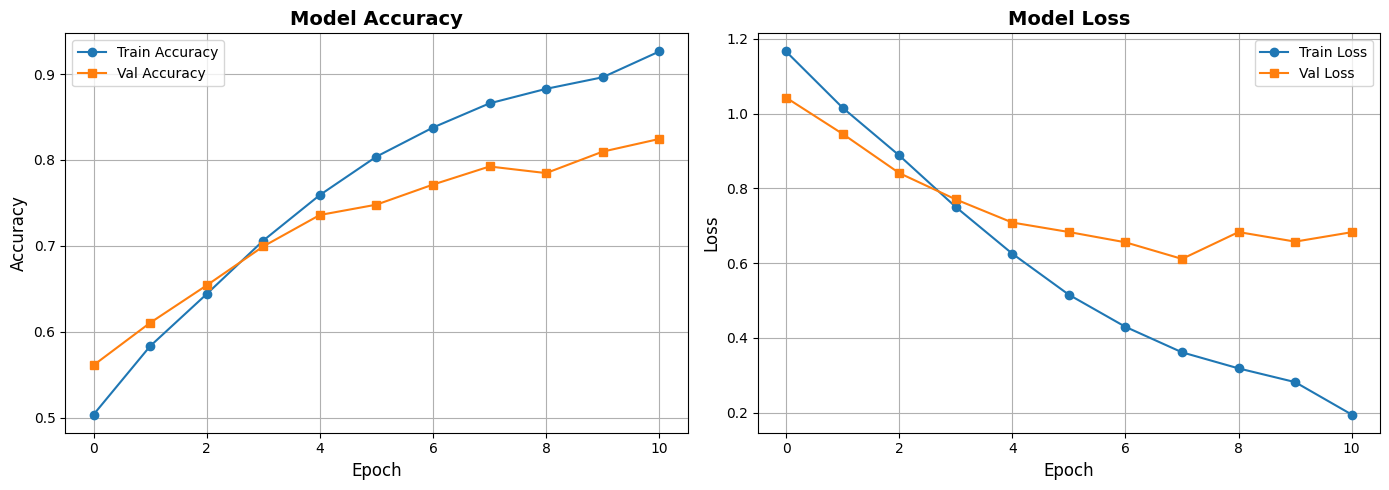

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss', marker='o')
axes[1].plot(history.history['val_loss'], label='Val Loss', marker='s')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

### EVALUATE ON TEST SET

In [44]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true_classes = np.argmax(y_test, axis = 1)

346/346 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step


In [45]:
# Calculate accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f'\nTest Accuracy: {accuracy:.4f}')
print(f'Test Accuracy: {accuracy*100:.2f}%')


Test Accuracy: 0.7911
Test Accuracy: 79.11%


In [48]:
label_map = {'Positive': 3, 'Negative': 1, 'Neutral': 2, 'Irrelevant': 0}

In [49]:
reverse_label_map = {v: k for k, v in label_map.items()}
class_names = [reverse_label_map[i] for i in range(4)]

print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

  Irrelevant       0.73      0.75      0.74      1923
    Negative       0.84      0.82      0.83      3339
     Neutral       0.74      0.77      0.76      2698
    Positive       0.82      0.81      0.81      3088

    accuracy                           0.79     11048
   macro avg       0.78      0.79      0.78     11048
weighted avg       0.79      0.79      0.79     11048



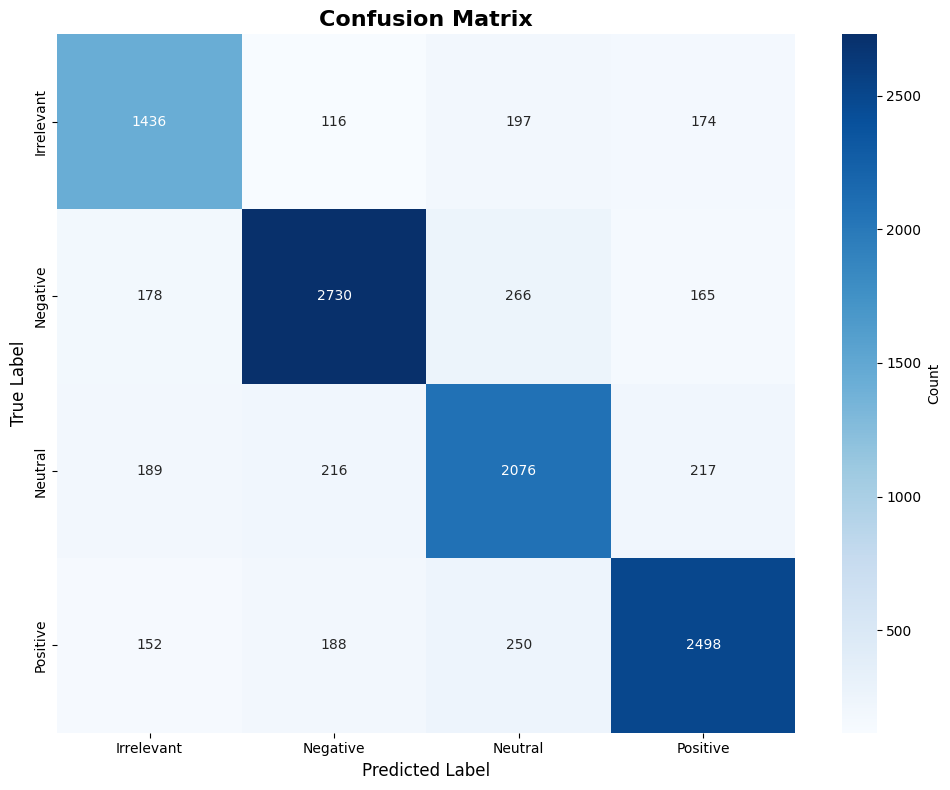

In [50]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()